# Credit Risk Analysis of Bank debtors

End-to-end data analytics project
Objective: Classify bank debtors as good or bad risks based on attributes

#### Data Preparation

Cleaning, handling missing values, and formatting dataset
Data exploration and understanding
#### Exploratory Data Analysis (EDA)

Pivot tables
Count plots with subplots
Facet grids with histograms
Bar plots
Side-by-side box plots
Violin plots with subplots
Correlation analysis using heatmap

#### Preprocessing

Tried dropping correlated columns to avoid multicollinearity
Converting target variable to binary using np.where()

#### Modeling

Categorical columns converted to binary with pd.get_dummies
Variance equalization with np.log
Train-test split
Np.log
StandardScaler

#### Machine Learning Techniques

* Random forest with GridSearchCV for hyperparameter tuning - mean accuracy of 71%, Credit amount, duration, Bank_account_type_SA, Sex_female, Bank_account_type_SA/CA, purpose_car, Housing_own
*Logistic Regression - doesn't includes credit amount though duration was removed. Not perfect whenn multicollineriarity exists
*Logistic Regression with Recursive Feature Elimination with Cross-Validation (RFECV) - though used LR as base model. Suggest optimal no. of features as 23. Top selected features Credit_amount, Duration, Sex_female,Housing_free, Housing_own, Housing_rent
*Logistic Regression with SelectKBest and Principal Component Analysis (PCA) for feature selection
Evaluation with 76% level accuracy, 'Credit_amount', 'Duration', 'Housing_own', 'Bank_account_type_None', 'Bank_account_type_SA', 'Bank_account_type_SA/CA'

#### Performance evaluation of each technique
Accuracy in classifying bank debtors as good or bad risks
Decision-making implications for lending institutions

## Introduction

In this project I'll explore the dataset that contains a list of persons who takes a credit by a bank classified as good or bad credit risks according to the set of attributes. 

Credits to this improved dataset https://www.kaggle.com/datasets/uciml/german-credit
    
    Age (numeric)
    Sex (text: male, female)
    Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    Housing (text: own, rent, or free)
    Saving accounts (text - little, moderate, quite rich, rich)
    Checking account (numeric, in DM - Deutsch Mark)
    Credit amount (numeric, in DM)
    Duration (numeric, in month)
    Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
    Risk (Value target - Good or Bad Risk)
    

## Import relevant libraries and the dataset

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import textwrap #for text wrapping in visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
df_credit = pd.read_csv("C:/Users/Shai/Documents/GitHub/python-projects/German credit risk analysis/german_credit_data.csv", index_col=0)

## Data preparation

In [3]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
#Check for null values and blanks and review data types
#From the data we can assume that the customer either have SA or CA or have both (to be confirmed later)
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [5]:
df_credit.shape

(1000, 10)

In [6]:
df_credit[["Saving accounts", "Checking account"]].isnull().sum()

Saving accounts     183
Checking account    394
dtype: int64

In [7]:
df_credit[df_credit["Credit amount"] == 0]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk


In [8]:
df_credit.Duration.unique()

array([ 6, 48, 12, 42, 24, 36, 30, 15,  9, 10,  7, 60, 18, 45, 11, 27,  8,
       54, 20, 14, 33, 21, 16,  4, 47, 13, 22, 39, 28,  5, 26, 72, 40],
      dtype=int64)

In [9]:
# Define mapping dictionary
job_labels = {
    0: "unskilled non-resident",
    1: "unskilled resident",
    2: "skilled",
    3: "highly skilled"
}

# Map numerical values to string labels
df_credit["Job"] = df_credit["Job"].map(job_labels)

In [10]:
#Age, credit and duration values are spreadout
#Assigned job as string
df_credit.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [11]:
#Created a categorical column(generation) for age 
interval = (11, 26, 42, 58, 77)#, 95

cats = ['Gen Z', 'Millenials', 'Gen X', 'Baby Boomers'] #, 'Silent Gen'
df_credit["Generation"] = pd.cut(df_credit.Age, interval, labels=cats)
#Removed Silent Gen since its zero

In [12]:
#Check categorical columns values and count
cat_cols = df_credit.select_dtypes(include=['object']).columns

for col in cat_cols:
    print(df_credit[col].value_counts(normalize=True).round(2), "\n")

male      0.69
female    0.31
Name: Sex, dtype: float64 

skilled                   0.63
unskilled resident        0.20
highly skilled            0.15
unskilled non-resident    0.02
Name: Job, dtype: float64 

own     0.71
rent    0.18
free    0.11
Name: Housing, dtype: float64 

little        0.74
moderate      0.13
quite rich    0.08
rich          0.06
Name: Saving accounts, dtype: float64 

little      0.45
moderate    0.44
rich        0.10
Name: Checking account, dtype: float64 

car                    0.34
radio/TV               0.28
furniture/equipment    0.18
business               0.10
education              0.06
repairs                0.02
domestic appliances    0.01
vacation/others        0.01
Name: Purpose, dtype: float64 

good    0.7
bad     0.3
Name: Risk, dtype: float64 



In [13]:
#Add new column to identify the account type of the bank customers
df_credit['Bank_account_type'] = 'None'

df_credit.loc[df_credit['Saving accounts'].notnull() & df_credit['Checking account'].notnull(), 'Bank_account_type'] = 'SA/CA'
df_credit.loc[df_credit['Saving accounts'].notnull() & df_credit['Checking account'].isnull(), 'Bank_account_type'] = 'SA'
df_credit.loc[df_credit['Saving accounts'].isnull() & df_credit['Checking account'].notnull(), 'Bank_account_type'] = 'CA'

In [14]:
df_credit['Bank_account_type'].value_counts()

SA/CA    522
SA       295
None      99
CA        84
Name: Bank_account_type, dtype: int64

In [15]:
pd.pivot_table(df_credit, values='Credit amount', index='Bank_account_type', columns='Job').round(2)

Job,highly skilled,skilled,unskilled non-resident,unskilled resident
Bank_account_type,,,,
CA,6365.71,3210.82,6589.40,2820.86
None,6373.40,3593.17,NaN,3068.80
SA,4336.95,2759.44,898.67,2274.49
SA/CA,5648.78,3129.13,1767.86,2250.72


In [16]:
df_credit[df_credit["Bank_account_type"] == 'None'].sort_values('Credit amount').tail(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Generation,Bank_account_type
657,37,male,skilled,own,NaN,NaN,10222,48,radio/TV,good,Millenials,None
902,42,male,skilled,free,NaN,NaN,10477,36,car,good,Millenials,None
450,30,male,highly skilled,own,NaN,NaN,11054,36,car,good,Millenials,None
763,30,male,highly skilled,free,NaN,NaN,12680,21,car,bad,Millenials,None
373,63,male,highly skilled,free,NaN,NaN,13756,60,car,good,Baby Boomers,None


## EDA

## Risk type

Text(0, 0.5, 'Count of Customers')

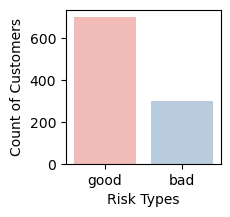

In [17]:
sns.set_palette("Pastel1")
plt.subplots(figsize=(2,2))
sns.countplot(data=df_credit, x='Risk')
plt.xlabel("Risk Types")
plt.ylabel("Count of Customers")

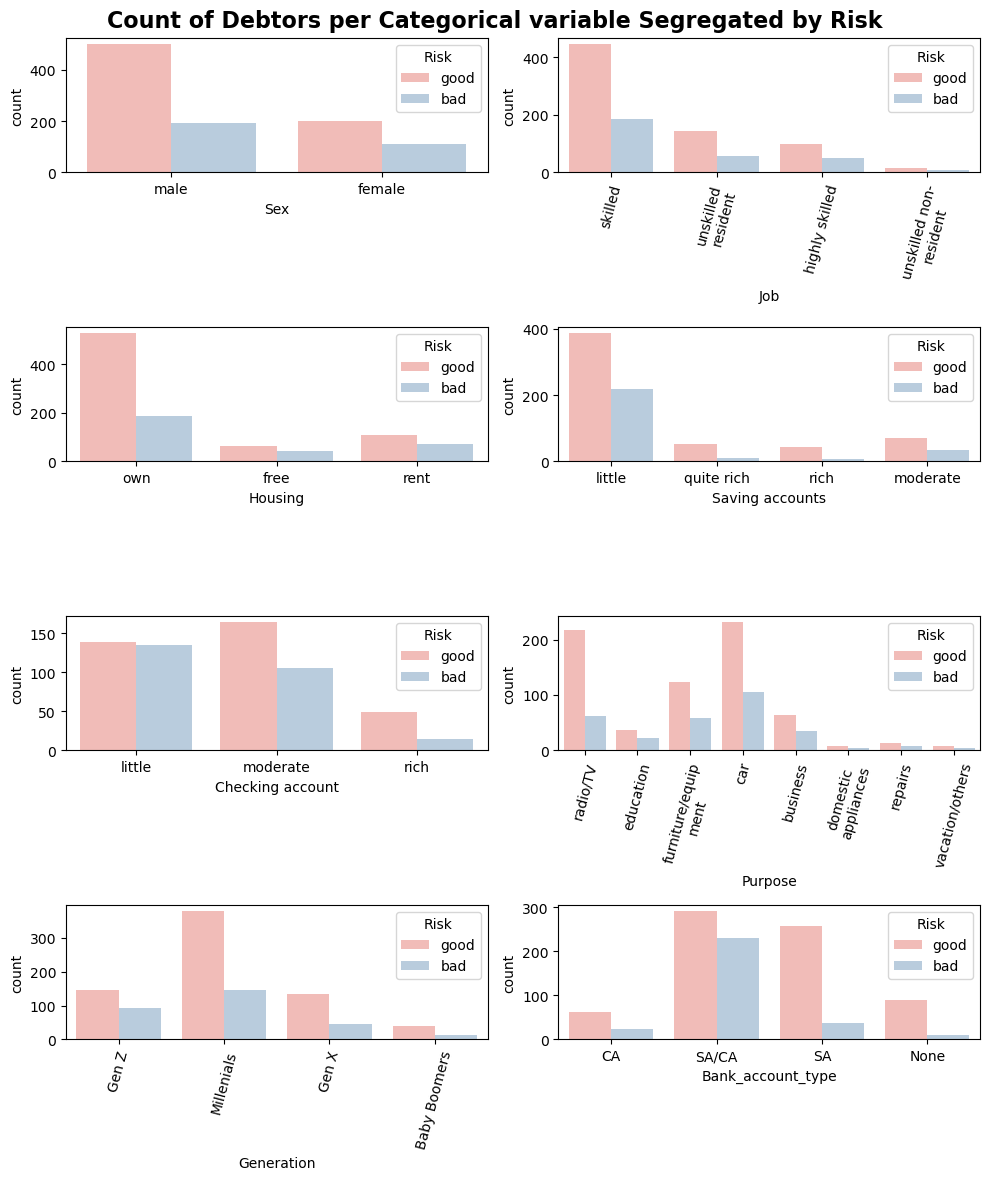

In [18]:
fig, ax = plt.subplots(4,2, figsize=(10,12))
sns.countplot(data=df_credit, x='Sex', hue='Risk', ax=ax[0,0])
sns.countplot(data=df_credit, x='Job', hue='Risk', ax=ax[0,1])
sns.countplot(data=df_credit, x='Housing', hue='Risk', ax=ax[1,0])
sns.countplot(data=df_credit, x='Saving accounts', hue='Risk', ax=ax[1,1])
sns.countplot(data=df_credit, x='Checking account', hue='Risk', ax=ax[2,0])
sns.countplot(data=df_credit, x='Purpose', hue='Risk', ax=ax[2,1])
sns.countplot(data=df_credit, x='Generation', hue='Risk', ax=ax[3,0])
sns.countplot(data=df_credit, x='Bank_account_type', hue='Risk', ax=ax[3,1])

wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0, 1].get_xticklabels()]
ax[0, 1].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[2, 1].get_xticklabels()]
ax[2, 1].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[3, 0].get_xticklabels()]
ax[3, 0].set_xticklabels(wrapped_labels, rotation=75)

fig.suptitle('Count of Debtors per Categorical variable Segregated by Risk', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- Male debtors exceed females in both risk types.
- Majority of the debtors are skilled; good credit risk exceeds bad credit risk for all job category.
- The majority of debtors have their own houses; those who rent and are living free have good credit risk that are slightly higher than bad credit risk.
- The majority of debtors are labeled as little when it comes to savings accounts and have the highest count when it comes to bad risk types.
- Many checking account debtors are labeled as little and moderate. Those who are little have only slight difference between risk type.
- Car, radio or TV, and furniture or equipment are the top three purposes of the debtors
- The majority of debtors are millenials.
- Many of those debtors that both have SA/CA accounts have high bad credit risk. While for those who only have SA accounts have a large difference when it comes to risk type.


## Credit amount

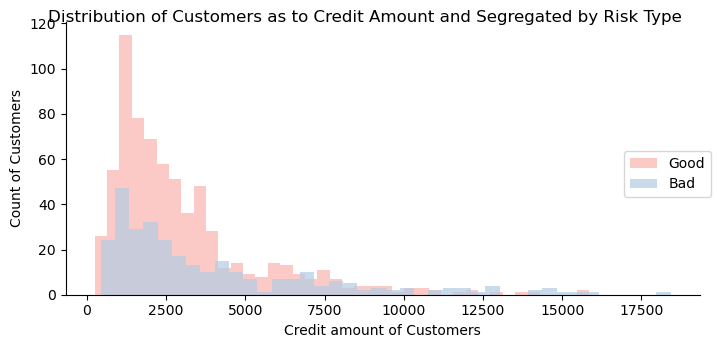

In [19]:
g = sns.FacetGrid(df_credit,hue="Risk",height=3.5, aspect=2)
g = g.map(plt.hist,'Credit amount',bins= 40, alpha=0.7)
g.fig.suptitle("Distribution of Customers as to Credit Amount and Segregated by Risk Type")
g.set_axis_labels("Credit amount of Customers", "Count of Customers")
handles, labels = g.axes[0][0].get_legend_handles_labels()
g.fig.legend(handles, ["Good", "Bad"], loc='center right')

### Risk % based on Credit amount per Categorical variable

<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

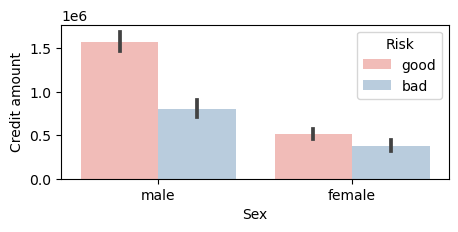

In [20]:
plt.subplots(figsize=(5,2))
sns.barplot(data=df_credit, x='Sex', y='Credit amount', hue='Risk', estimator=sum)
#y-axis values are being displayed in scientific notation or exponential form
#le6 stands for "times 10 to the power of 6", which means that the values on the y-axis are being multiplied by 1,000,000.

In [21]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Sex', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Sex,female,male
Risk,,
bad,42.0,34.0
good,58.0,66.0


**Female debtors have higher bad credit risk at 42% compared to 34% of male**

<AxesSubplot:xlabel='Job', ylabel='Credit amount'>

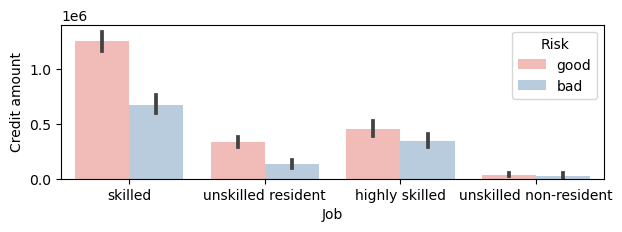

In [22]:
plt.subplots(figsize=(7,2))
sns.barplot(data=df_credit, x='Job', y='Credit amount', hue='Risk', estimator=sum)

In [23]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Job', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Job,highly skilled,skilled,unskilled non-resident,unskilled resident
Risk,,,,
bad,43.0,35.0,37.0,28.0
good,57.0,65.0,63.0,72.0


**Highly skilled debtors have the highest bad credit risk at 43%. Though the count and amount of credit by unskilled nonresidents are low, it's the second-highest risk at 37%.**

<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

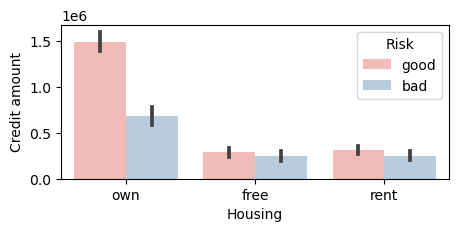

In [24]:
plt.subplots(figsize=(5,2))
sns.barplot(data=df_credit, x='Housing', y='Credit amount', hue='Risk', estimator=sum)

In [25]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Housing', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Housing,free,own,rent
Risk,,,
bad,46.0,31.0,45.0
good,54.0,69.0,55.0


**Rent and free housing have the highest bad credit risk at 46% and 45% respectively**

<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

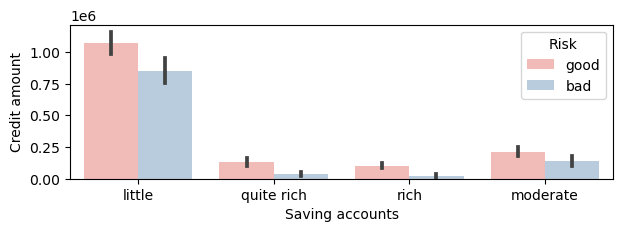

In [26]:
plt.subplots(figsize=(7,2))
sns.barplot(data=df_credit, x='Saving accounts', y='Credit amount', hue='Risk', estimator=sum)

In [27]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Saving accounts', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Saving accounts,little,moderate,quite rich,rich
Risk,,,,
bad,44.0,39.0,21.0,16.0
good,56.0,61.0,79.0,84.0


**Little and moderate amount SA debtors have the highest bad credit risk at 44% and 39% respectively. Rich have low bad credit risk at 16%**

<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

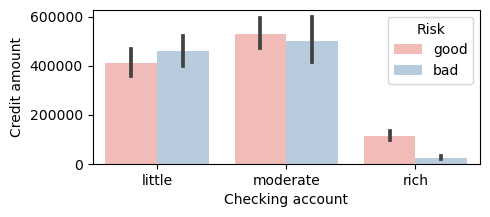

In [28]:
plt.subplots(figsize=(5,2))
sns.barplot(data=df_credit, x='Checking account', y='Credit amount', hue='Risk', estimator=sum)

In [29]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Checking account', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Checking account,little,moderate,rich
Risk,,,
bad,53.0,48.0,18.0
good,47.0,52.0,82.0


**Little and moderate amount CA debtors have the highest bad credit risk at 53% and 48% respectively. Rich have lowest bad credit risk at 18%**

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'radio/TV'),
  Text(1, 0, 'education'),
  Text(2, 0, 'furniture/equipment'),
  Text(3, 0, 'car'),
  Text(4, 0, 'business'),
  Text(5, 0, 'domestic appliances'),
  Text(6, 0, 'repairs'),
  Text(7, 0, 'vacation/others')])

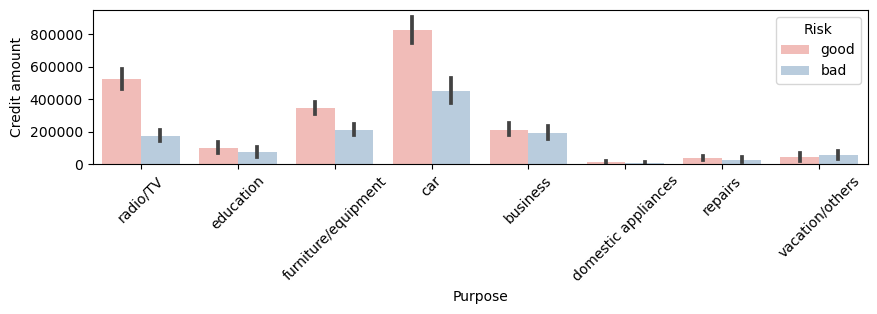

In [30]:
plt.subplots(figsize=(10,2))
sns.barplot(data=df_credit, x='Purpose', y='Credit amount', hue='Risk', estimator=sum)
plt.xticks(rotation=45)

In [31]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Purpose', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Risk,,,,,,,,
bad,47.0,35.0,35.0,43.0,38.0,25.0,37.0,59.0
good,53.0,65.0,65.0,57.0,62.0,75.0,63.0,41.0


**Vacation/others, business and education are the purposes that have the highest bad credit risk at 59%, 47% and 43% respectively. Radio/tv have the second highest count for debtors yet have the lowest bad risk at 25%.**

<AxesSubplot:xlabel='Generation', ylabel='Credit amount'>

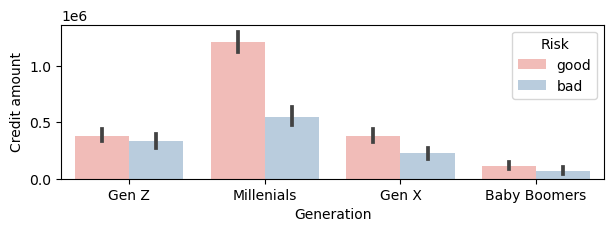

In [32]:
plt.subplots(figsize=(7,2))
sns.barplot(data=df_credit, x='Generation', y='Credit amount', hue='Risk', estimator=sum)

In [33]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Generation', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Generation,Gen Z,Millenials,Gen X,Baby Boomers
Risk,,,,
bad,47.0,31.0,37.0,38.0
good,53.0,69.0,63.0,62.0


**Gen Z have the highest bad credit risk at 47%.**

<AxesSubplot:xlabel='Bank_account_type', ylabel='Credit amount'>

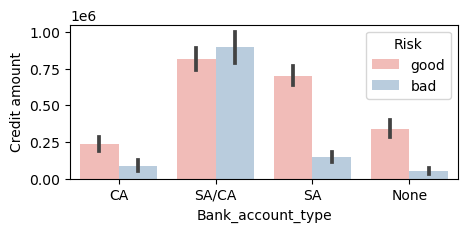

In [34]:
plt.subplots(figsize=(5,2))
sns.barplot(data=df_credit, x='Bank_account_type', y='Credit amount', hue='Risk', estimator=sum)

In [35]:
df_credit.pivot_table(index='Risk', values='Credit amount', columns='Bank_account_type', aggfunc='sum', fill_value=0).apply(lambda col: col / col.sum() * 100, axis=0).round()

Bank_account_type,CA,None,SA,SA/CA
Risk,,,,
bad,27.0,13.0,17.0,52.0
good,73.0,87.0,83.0,48.0


**Those who both have SA/CA bank accounts have the highest bad credit risk at 52% .**

### Credit amount distribution per categorical variable

<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

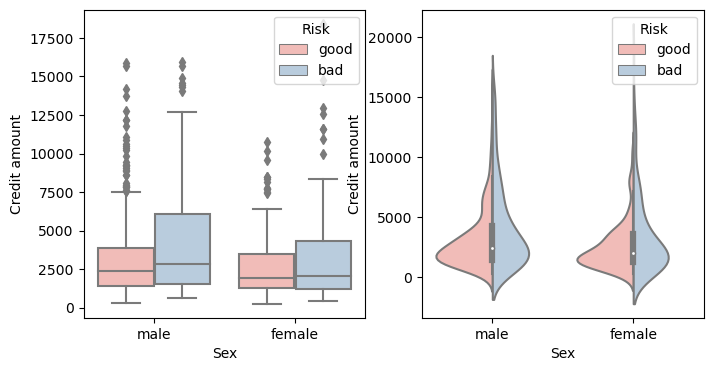

In [36]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.boxplot(data=df_credit, x='Sex', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Sex', y='Credit amount', hue='Risk', split=True,ax = ax[1])

**Male have wider credit range and have many outlier values. Male with bad credit risk have higher credit range**

[Text(0, 0, 'skilled'),
 Text(1, 0, 'unskilled\nresident'),
 Text(2, 0, 'highly skilled'),
 Text(3, 0, 'unskilled non-\nresident')]

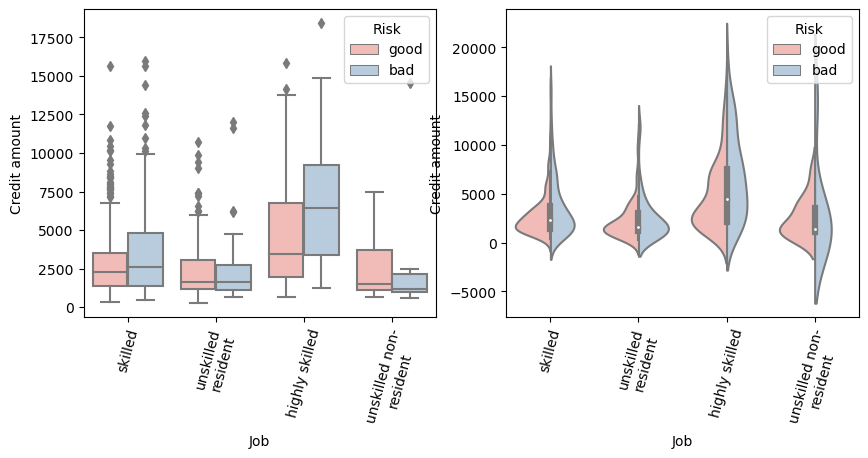

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Job', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Job', y='Credit amount', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Highly skilled have widest credit range and the the mean of good credit risk is only the lower boundary of bad credit risk. Skilled and unskilled resident have many outlier values at the higher amount. For unskilled resident, bad credit risk have a smallest range at the lower credit amount.**

<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

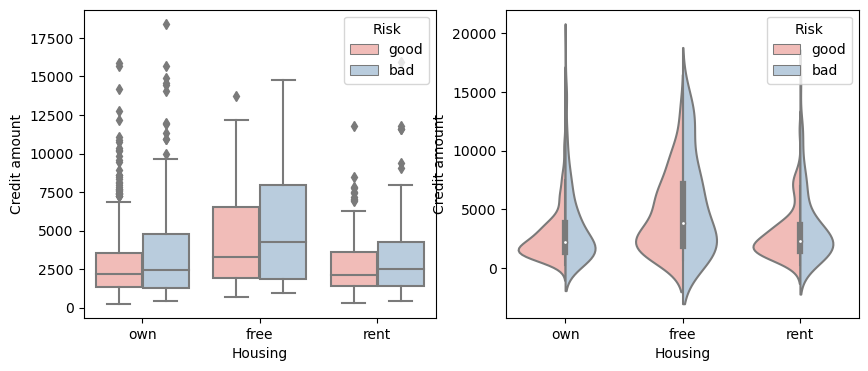

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Housing', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Housing', y='Credit amount', hue='Risk', split=True,ax = ax[1])

**Debtors who have free housing  have wider credit range. Those who own and rent have many outlier values though**

<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

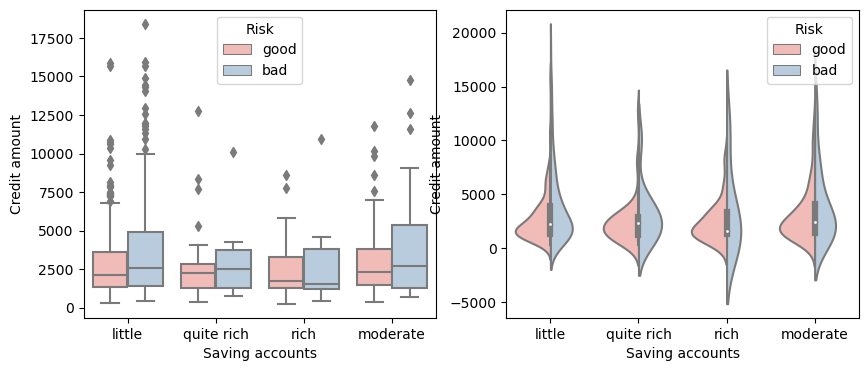

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Saving accounts', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Saving accounts', y='Credit amount', hue='Risk', split=True,ax = ax[1])

**Debtors who have little savings account have widest credit range and have many outliers at higher amount. The mean for all savings account type doesn't exceed 3,000.00**

<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

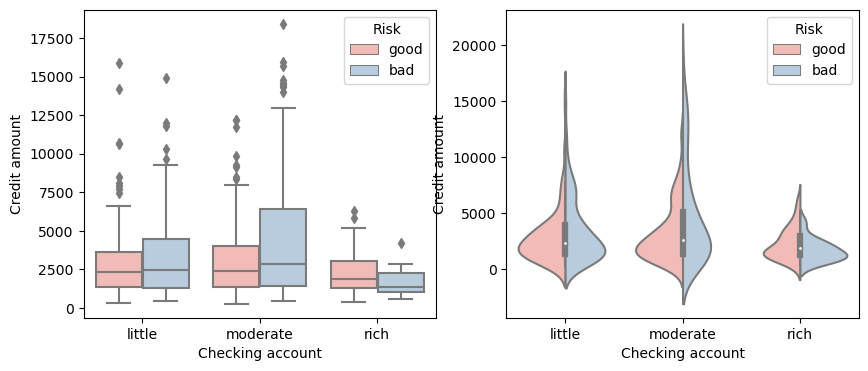

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Checking account', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Checking account', y='Credit amount', hue='Risk', split=True,ax = ax[1])

**Debtors who have moderate checking account have widest credit range and rich have smallest credit range. Little and moderate have many outliers at higher credit amount. The mean for all savings account type doesn't exceed 3,000.00**

[Text(0, 0, 'radio/TV'),
 Text(1, 0, 'education'),
 Text(2, 0, 'furniture/equip\nment'),
 Text(3, 0, 'car'),
 Text(4, 0, 'business'),
 Text(5, 0, 'domestic\nappliances'),
 Text(6, 0, 'repairs'),
 Text(7, 0, 'vacation/others')]

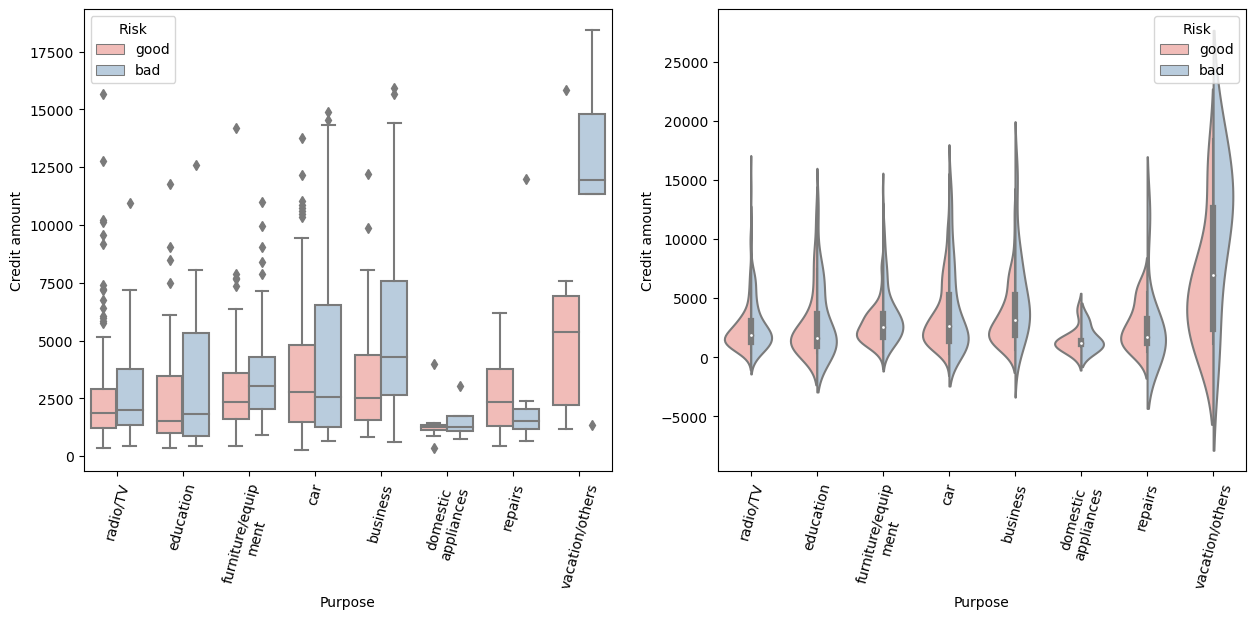

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df_credit, x='Purpose', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Purpose', y='Credit amount', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Car and business purpose have widest credit range. Radio/tv, education and furniture/equipment have many outliers at the higher credit amount. Domestic appliances have the smallest credit range. Debtors who have bad credit risk and have vacation others as purpose have a credit range far at the top/higher amount.**

[Text(0, 0, 'Gen Z'),
 Text(1, 0, 'Millenials'),
 Text(2, 0, 'Gen X'),
 Text(3, 0, 'Baby Boomers')]

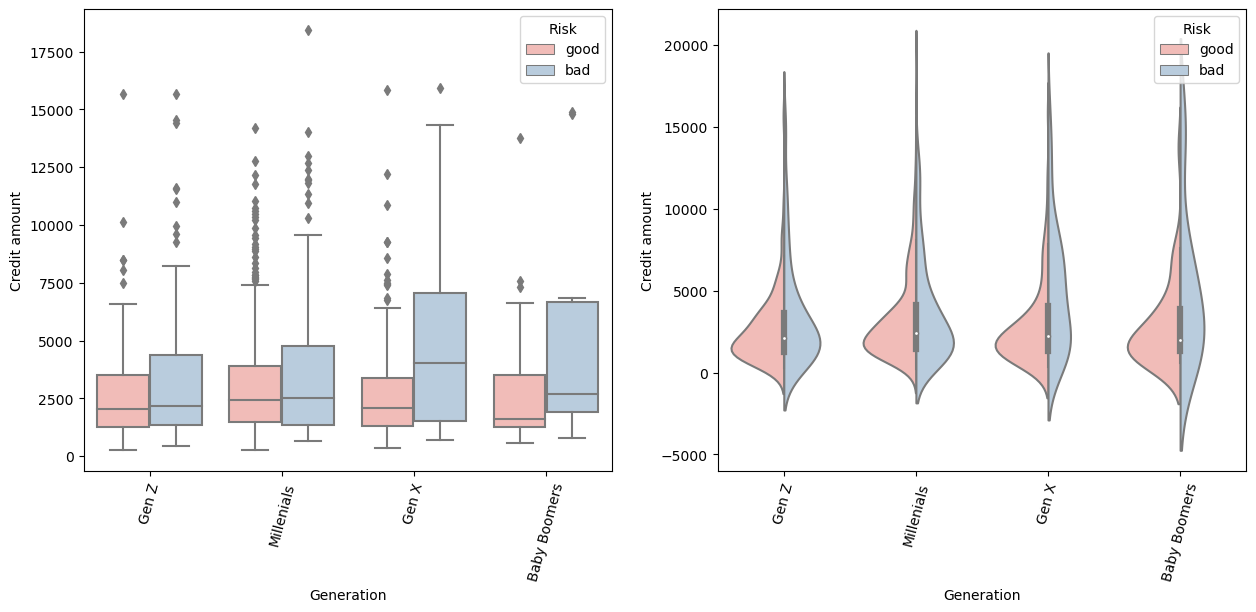

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df_credit, x='Generation', y='Credit amount', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Generation', y='Credit amount', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Gen X have widest credit range and those who have bad credit have a mean credit amount at arounf 3,800.00. All except silent gen have outliers for their credit amount.**

Violin plot provides a similar summary to a box plot, but with additional information about the density of the data at different values. The width of the violin at a given point represents the density of the data at that point.

## Duration

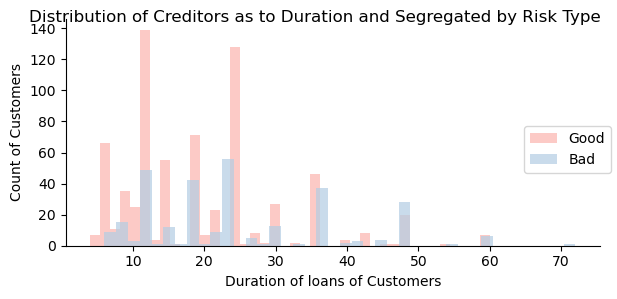

In [43]:
g = sns.FacetGrid(df_credit,hue="Risk",height=3, aspect=2)
g = g.map(plt.hist,'Duration',bins=40,alpha=0.7)
g.fig.suptitle("Distribution of Creditors as to Duration and Segregated by Risk Type")
g.set_axis_labels("Duration of loans of Customers", "Count of Customers")
handles, labels = g.axes[0][0].get_legend_handles_labels()
g.fig.legend(handles, ["Good", "Bad"], loc='center right')

**Bad credit risk creditors have the longest duration at 70 days and good credit risk creditors have shortest duration at around 5 days.**

<AxesSubplot:xlabel='Sex', ylabel='Duration'>

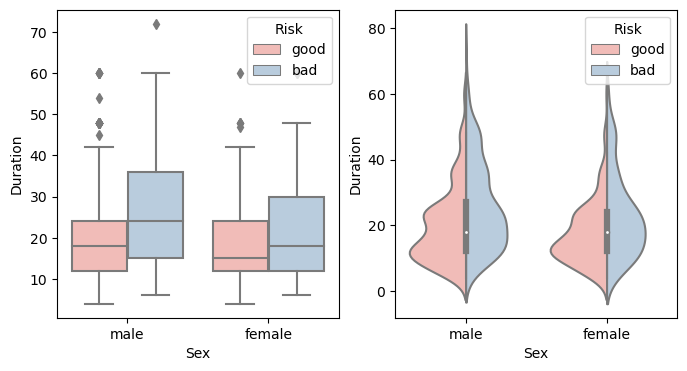

In [44]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.boxplot(data=df_credit, x='Sex', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Sex', y='Duration', hue='Risk', split=True,ax = ax[1])

**Males who have bad credit rating have wider duration days while those who have good credit rating have lower mean and many outliers at the higher duration days.**

[Text(0, 0, 'skilled'),
 Text(1, 0, 'unskilled\nresident'),
 Text(2, 0, 'highly skilled'),
 Text(3, 0, 'unskilled non-\nresident')]

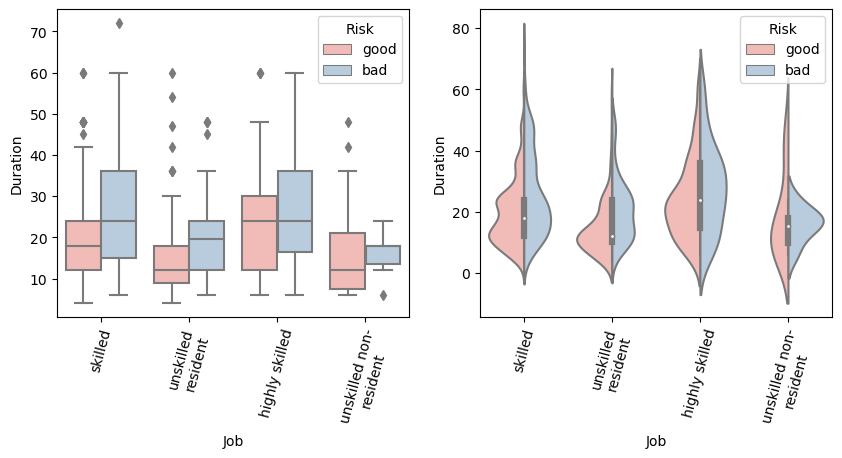

In [45]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Job', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Job', y='Duration', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Skilled and highly skilled who have bad credit rating (BCR) have higher mean duration and spread out IQR. Additionally, highly skilled with good credit rating(GCR) have the same mean with that who have BCR but the lower boundary of those who are GCR are much lower than the BCR**

<AxesSubplot:xlabel='Housing', ylabel='Duration'>

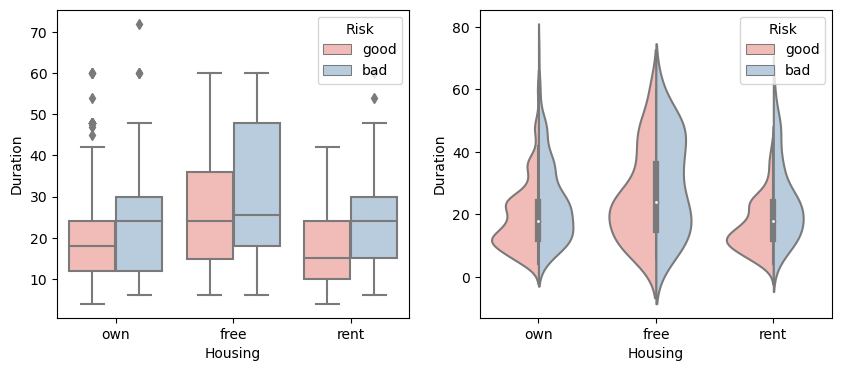

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Housing', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Housing', y='Duration', hue='Risk', split=True,ax = ax[1])

**For all housing types, those who have BCR have higher IQR, but for own and free housing the mean of BCR and GCR have greater diff.**

<AxesSubplot:xlabel='Saving accounts', ylabel='Duration'>

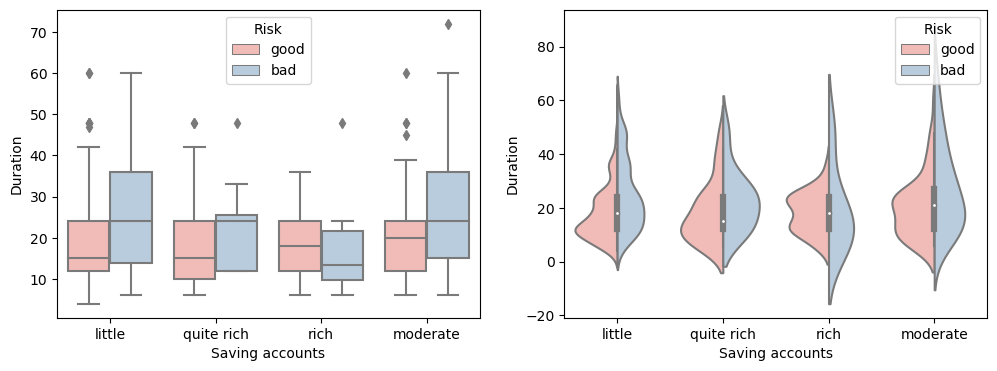

In [47]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(data=df_credit, x='Saving accounts', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Saving accounts', y='Duration', hue='Risk', split=True,ax = ax[1])

**All except rich, have higher mean for BCR than GCR.**

<AxesSubplot:xlabel='Checking account', ylabel='Duration'>

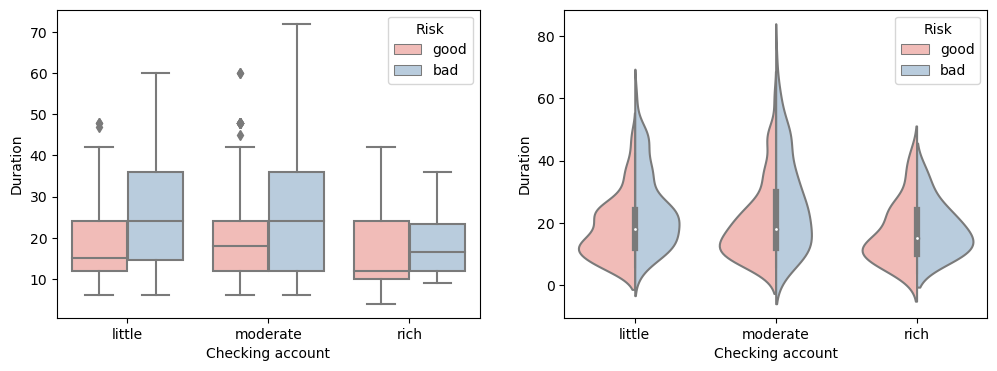

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(data=df_credit, x='Checking account', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Checking account', y='Duration', hue='Risk', split=True,ax = ax[1])

**Debtors with moderate checking account have widest duration range. For rich, those have GCR have wider duration range than BCR.**

[Text(0, 0, 'radio/TV'),
 Text(1, 0, 'education'),
 Text(2, 0, 'furniture/equip\nment'),
 Text(3, 0, 'car'),
 Text(4, 0, 'business'),
 Text(5, 0, 'domestic\nappliances'),
 Text(6, 0, 'repairs'),
 Text(7, 0, 'vacation/others')]

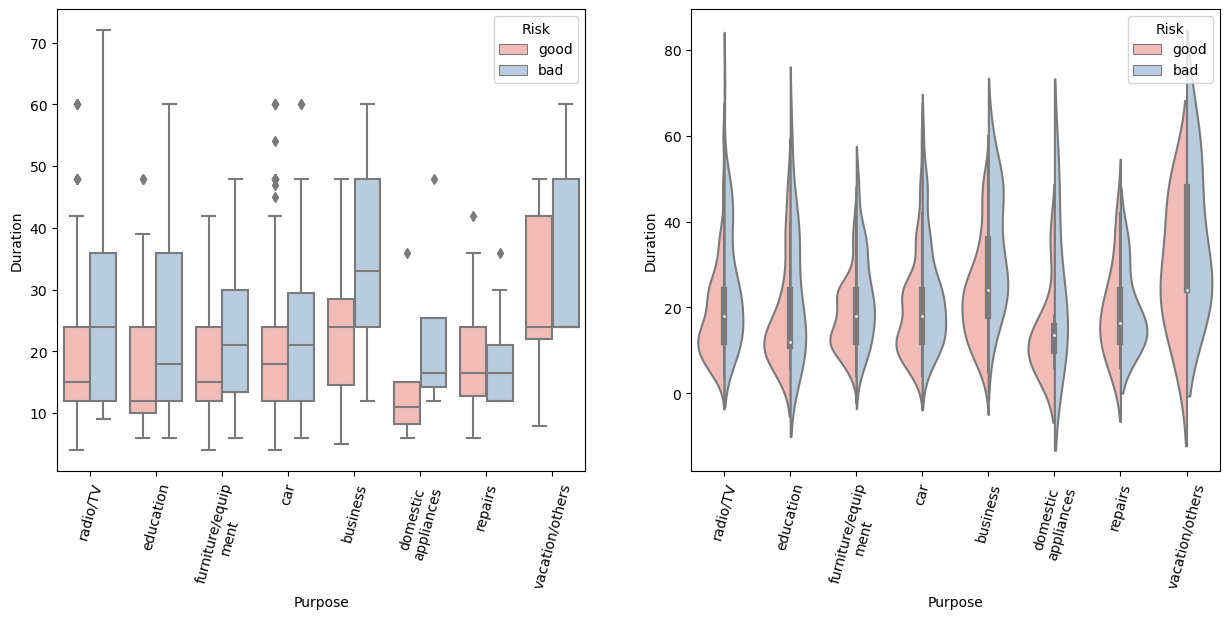

In [49]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df_credit, x='Purpose', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Purpose', y='Duration', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Debtors who have BCR and have business and vacation/others as purpose have duration range at the longer days. Debtors who have BCR and have  radio/TV as purpose have the widest duration range.**

[Text(0, 0, 'Gen Z'),
 Text(1, 0, 'Millenials'),
 Text(2, 0, 'Gen X'),
 Text(3, 0, 'Baby Boomers')]

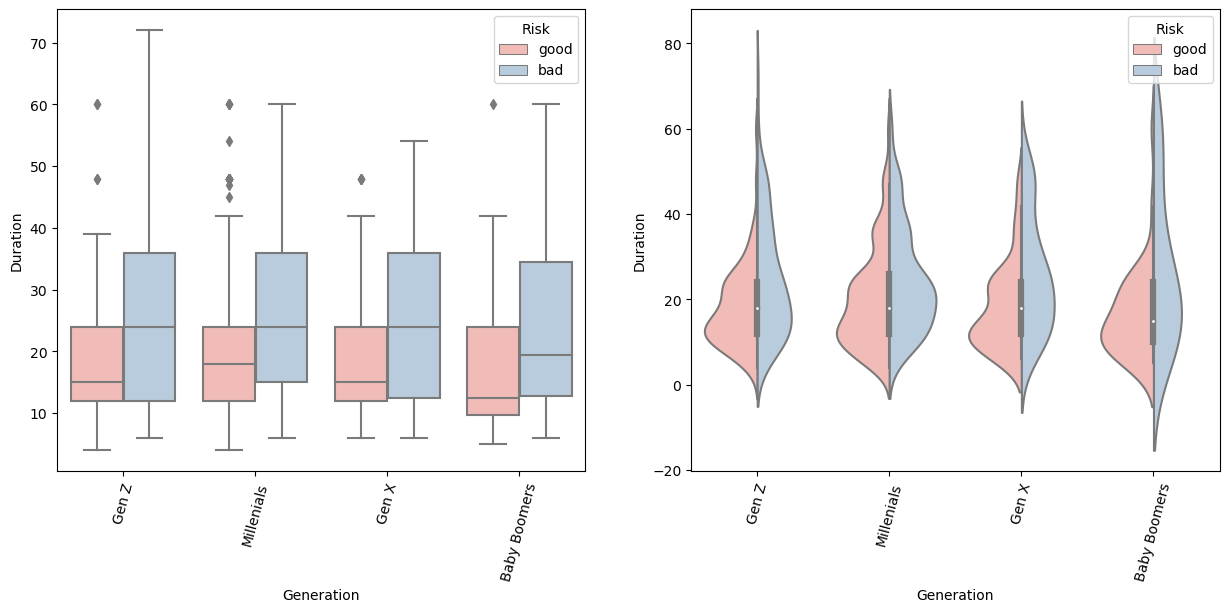

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df_credit, x='Generation', y='Duration', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Generation', y='Duration', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Debtors who have BCR and are millenials have the widest duration range.**

## Age

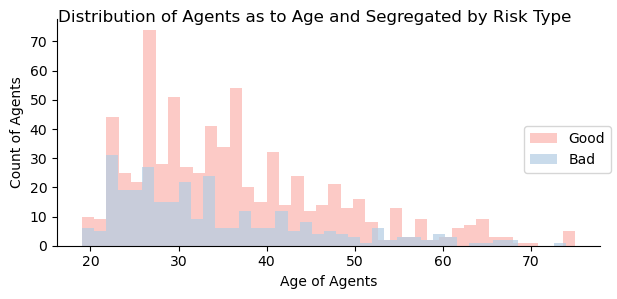

In [51]:
g = sns.FacetGrid(df_credit,hue="Risk",height=3, aspect=2)
g = g.map(plt.hist,'Age',bins=40,alpha=0.7)
g.fig.suptitle("Distribution of Agents as to Age and Segregated by Risk Type")
g.set_axis_labels("Age of Agents", "Count of Agents")
handles, labels = g.axes[0][0].get_legend_handles_labels()
g.fig.legend(handles, ["Good", "Bad"], loc='center right')

<AxesSubplot:xlabel='Sex', ylabel='Age'>

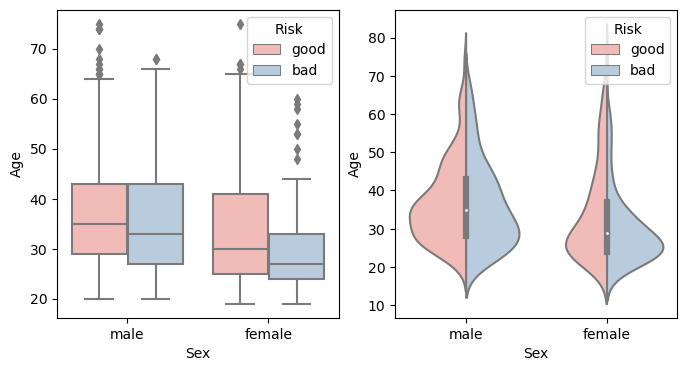

In [52]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.boxplot(data=df_credit, x='Sex', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Sex', y='Age', hue='Risk', split=True,ax = ax[1])

**Female with BCR have a shortest age range and have many outliers.**

[Text(0, 0, 'skilled'),
 Text(1, 0, 'unskilled\nresident'),
 Text(2, 0, 'highly skilled'),
 Text(3, 0, 'unskilled non-\nresident')]

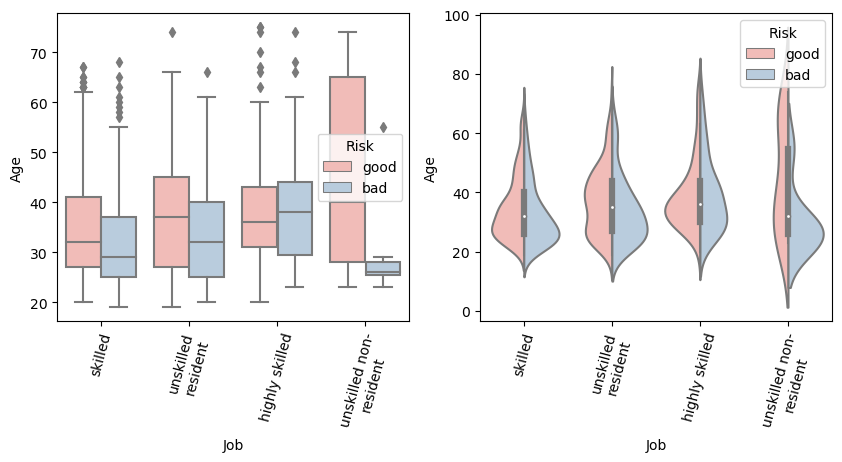

In [53]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Job', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Job', y='Age', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Unskilled non-resident with BCR have the shortest age range while those with GCR have the longest age.**

<AxesSubplot:xlabel='Housing', ylabel='Age'>

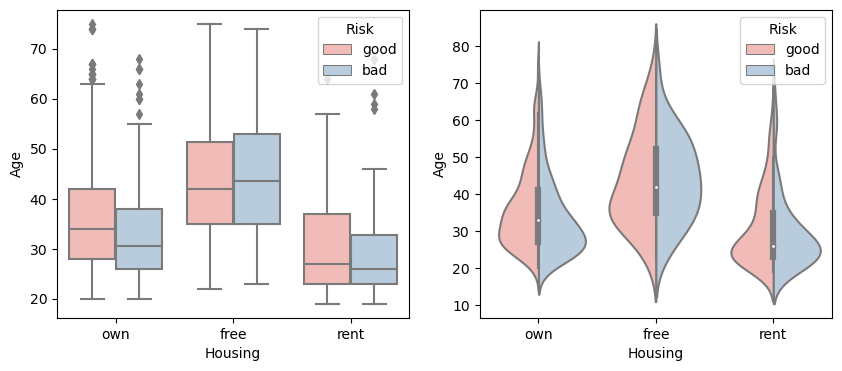

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Housing', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Housing', y='Age', hue='Risk', split=True,ax = ax[1])

**Those who have free housing have wider age range.**

<AxesSubplot:xlabel='Saving accounts', ylabel='Age'>

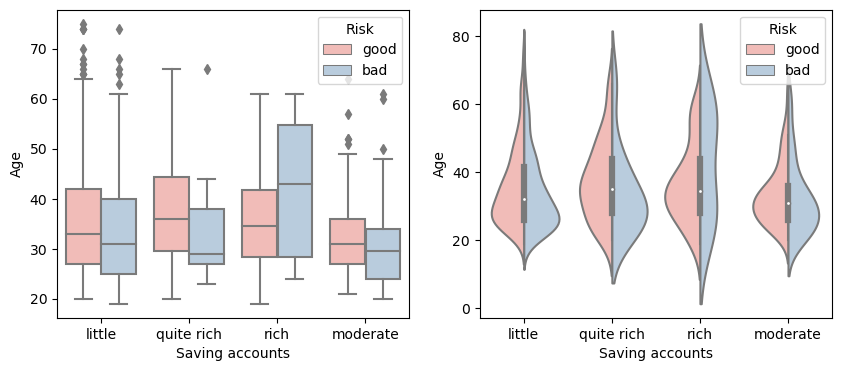

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Saving accounts', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Saving accounts', y='Age', hue='Risk', split=True,ax = ax[1])

**Those with little and moderate savings account have many outliers at the higher age.**

<AxesSubplot:xlabel='Checking account', ylabel='Age'>

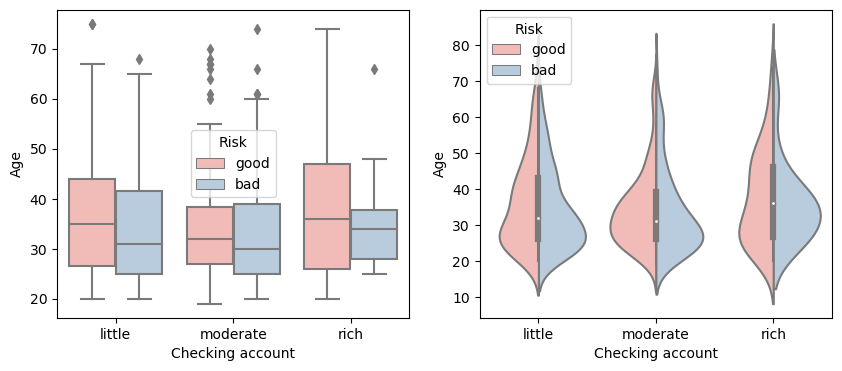

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Checking account', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Checking account', y='Age', hue='Risk', split=True,ax = ax[1])

**Those with moderate checking account have many outliers at the higher age. Those rich with BCR have shortest are range.**

[Text(0, 0, 'radio/TV'),
 Text(1, 0, 'education'),
 Text(2, 0, 'furniture/equip\nment'),
 Text(3, 0, 'car'),
 Text(4, 0, 'business'),
 Text(5, 0, 'domestic\nappliances'),
 Text(6, 0, 'repairs'),
 Text(7, 0, 'vacation/others')]

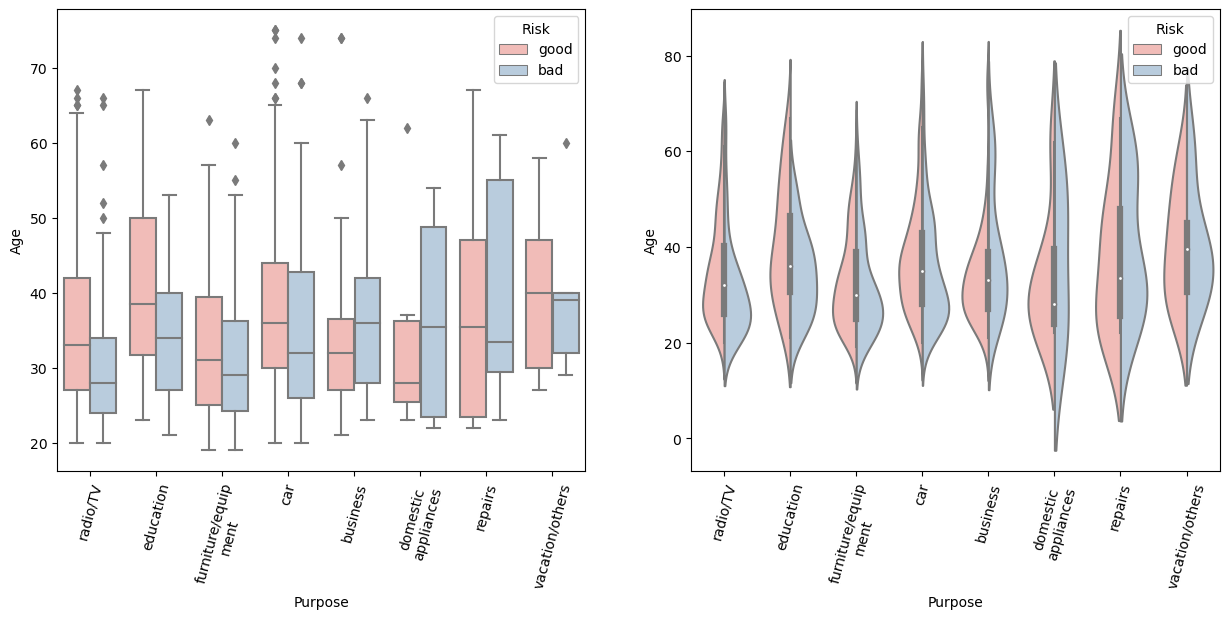

In [57]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(data=df_credit, x='Purpose', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Purpose', y='Age', hue='Risk', split=True,ax = ax[1])
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[0].get_xticklabels()]
ax[0].set_xticklabels(wrapped_labels, rotation=75)
wrapped_labels = [textwrap.fill(label.get_text(), 15) for label in ax[1].get_xticklabels()]
ax[1].set_xticklabels(wrapped_labels, rotation=75)

**Debtors who have car as purpose have many outliers at the older age. Debtors who have vacation/others as purpose and ahve BCR have shorter age range around 30s-40s.**

<AxesSubplot:xlabel='Bank_account_type', ylabel='Age'>

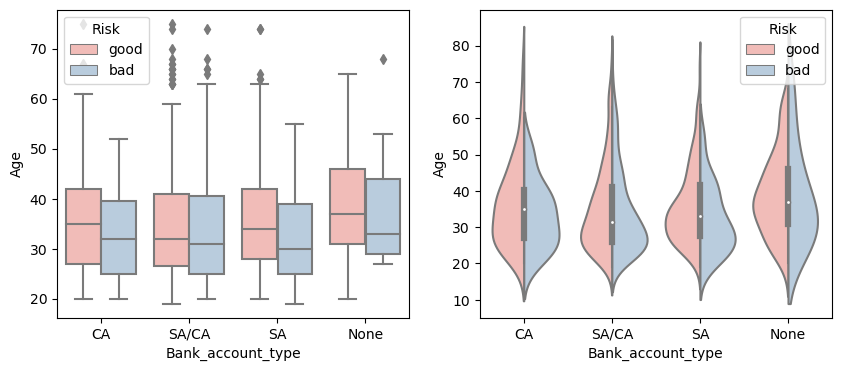

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=df_credit, x='Bank_account_type', y='Age', hue='Risk',ax = ax[0])
sns.violinplot(data=df_credit, x='Bank_account_type', y='Age', hue='Risk', split=True,ax = ax[1])

**SA/CA debtors have many outlier values.**

## Correlation

In [59]:
continuous = df_credit.select_dtypes(include=['int']).columns

In [60]:
df_conti = pd.DataFrame(df_credit, columns=continuous)

<AxesSubplot:>

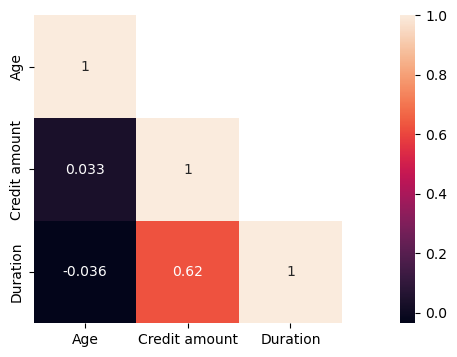

In [61]:
cor_mat = df_conti.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(15,4)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True)

**Credit amount and duration is positively correlated at 0.62**

CA and duration (linegraph) age job and risk, SA and job,  CA and job, housing and job, 
cross tab  sex and purpose, sex and CA

## Preprocessing

#### Missing values

In [62]:
df_credit["Saving accounts"].fillna(df_credit['Saving accounts'].mode()[0], inplace=True)
df_credit["Checking account"].fillna(df_credit['Checking account'].mode()[0], inplace=True)

In [63]:
df_credit.rename(columns={"Saving accounts": "Savings_account", "Checking account":"Checking_account", "Credit amount":"Credit_amount"}, inplace=True)

In [64]:
#drop duration since its correlated with credit_amount, initially did this but the rfecv doesnt provide a reliable ranking of features
df_credit = df_credit.drop(['Age'], axis=1) #,'Duration'


In [65]:
df_credit["Risk"] = np.where(df_credit["Risk"] == "bad", 1,0)

In [66]:
df_credit.head()

,Sex,Job,Housing,Savings_account,Checking_account,Credit_amount,Duration,Purpose,Risk,Generation,Bank_account_type
0,male,skilled,own,little,little,1169,6,radio/TV,0,Baby Boomers,CA
1,female,skilled,own,little,moderate,5951,48,radio/TV,1,Gen Z,SA/CA
2,male,unskilled resident,own,little,little,2096,12,education,0,Gen X,SA
3,male,skilled,free,little,little,7882,42,furniture/equipment,0,Gen X,SA/CA
4,male,skilled,free,little,little,4870,24,car,1,Gen X,SA/CA


## Modeling

In [67]:
#to have a list of categorical columns
categorical_col = df_credit.select_dtypes(include=['object', 'category'])
print(categorical_col.columns)

Index(['Sex', 'Job', 'Housing', 'Savings_account', 'Checking_account',
       'Purpose', 'Generation', 'Bank_account_type'],
      dtype='object')


In [68]:
#Converted dummy variable to 0,1 values
df_cat = pd.get_dummies(categorical_col)

In [69]:
df_cat.head()

,Sex_female,Sex_male,Job_highly skilled,Job_skilled,Job_unskilled non-resident,Job_unskilled resident,Housing_free,Housing_own,Housing_rent,Savings_account_little,...,Purpose_repairs,Purpose_vacation/others,Generation_Gen Z,Generation_Millenials,Generation_Gen X,Generation_Baby Boomers,Bank_account_type_CA,Bank_account_type_None,Bank_account_type_SA,Bank_account_type_SA/CA
0,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,1,0,0,0
1,1,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0
3,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [70]:
df_cat = df_cat.drop(['Sex_male'], axis=1)

In [71]:
df_final = pd.concat([df_credit[["Risk","Credit_amount", "Duration"]],df_cat], axis=1)
df_final.head()

,Risk,Credit_amount,Duration,Sex_female,Job_highly skilled,Job_skilled,Job_unskilled non-resident,Job_unskilled resident,Housing_free,Housing_own,...,Purpose_repairs,Purpose_vacation/others,Generation_Gen Z,Generation_Millenials,Generation_Gen X,Generation_Baby Boomers,Bank_account_type_CA,Bank_account_type_None,Bank_account_type_SA,Bank_account_type_SA/CA
0,0,1169,6,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,1,5951,48,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,2096,12,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0
3,0,7882,42,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,1,4870,24,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [72]:
final_X = df_final.drop(["Risk"], axis=1)
final_y = df_final["Risk"]

In [73]:
final_X.var()

Credit_amount                  7.967843e+06
Duration                       1.454150e+02
Sex_female                     2.141141e-01
Job_highly skilled             1.262222e-01
Job_skilled                    2.333333e-01
Job_unskilled non-resident     2.153754e-02
Job_unskilled resident         1.601602e-01
Housing_free                   9.643243e-02
Housing_own                    2.048358e-01
Housing_rent                   1.471061e-01
Savings_account_little         1.683724e-01
Savings_account_moderate       9.248348e-02
Savings_account_quite rich     5.909009e-02
Savings_account_rich           4.574174e-02
Checking_account_little        2.219980e-01
Checking_account_moderate      1.968358e-01
Checking_account_rich          5.909009e-02
Purpose_business               8.767868e-02
Purpose_car                    2.236547e-01
Purpose_domestic appliances    1.186787e-02
Purpose_education              5.557457e-02
Purpose_furniture/equipment    1.483874e-01
Purpose_radio/TV               2

In [74]:
#Taking the logarithm of the data can help equalize variances especially in Credit_amount
final_X['Credit_amount'] = np.log(final_X['Credit_amount'])
final_X['Duration'] = np.log(final_X['Duration'])

In [75]:
final_X.var()

Credit_amount                  0.602912
Duration                       0.339003
Sex_female                     0.214114
Job_highly skilled             0.126222
Job_skilled                    0.233333
Job_unskilled non-resident     0.021538
Job_unskilled resident         0.160160
Housing_free                   0.096432
Housing_own                    0.204836
Housing_rent                   0.147106
Savings_account_little         0.168372
Savings_account_moderate       0.092483
Savings_account_quite rich     0.059090
Savings_account_rich           0.045742
Checking_account_little        0.221998
Checking_account_moderate      0.196836
Checking_account_rich          0.059090
Purpose_business               0.087679
Purpose_car                    0.223655
Purpose_domestic appliances    0.011868
Purpose_education              0.055575
Purpose_furniture/equipment    0.148387
Purpose_radio/TV               0.201802
Purpose_repairs                0.021538
Purpose_vacation/others        0.011868


In [76]:
X_train, X_test, y_train, y_test = train_test_split(final_X, final_y, test_size=0.3, random_state=7) #stratify=final_y

In [77]:
y_test.value_counts()

0    217
1     83
Name: Risk, dtype: int64

In [78]:
y_train.value_counts()

0    483
1    217
Name: Risk, dtype: int64

In [100]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


### Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc.fit(X_train_scaled, y_train)
rfc_pred = rfc.predict(X_test_scaled)

In [102]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3, 5, 7, 10, None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.114 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.023 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.000 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.000 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.159 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.023 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.023 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.023 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/5] END max_depth=3, max_feature

[CV 3/5] END max_depth=3, max_features=20, n_estimators=5;, score=0.256 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=20, n_estimators=5;, score=0.140 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=20, n_estimators=5;, score=0.233 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.205 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.250 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.186 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.140 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=20, n_estimators=10;, score=0.209 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.205 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.227 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=20, n_estimators=25;, score=0.302 total time

[CV 5/5] END max_depth=5, max_features=15, n_estimators=10;, score=0.233 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=15, n_estimators=25;, score=0.205 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=15, n_estimators=25;, score=0.295 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=15, n_estimators=25;, score=0.395 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=15, n_estimators=25;, score=0.163 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=15, n_estimators=25;, score=0.233 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=15, n_estimators=50;, score=0.182 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=15, n_estimators=50;, score=0.250 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=15, n_estimators=50;, score=0.395 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=15, n_estimators=50;, score=0.163 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=15, n_estimators=50;, score=0.233 total t

[CV 2/5] END max_depth=7, max_features=7, n_estimators=25;, score=0.386 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=7, n_estimators=25;, score=0.395 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=7, n_estimators=25;, score=0.326 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=7, n_estimators=25;, score=0.279 total time=   0.0s
[CV 1/5] END max_depth=7, max_features=7, n_estimators=50;, score=0.182 total time=   0.0s
[CV 2/5] END max_depth=7, max_features=7, n_estimators=50;, score=0.318 total time=   0.0s
[CV 3/5] END max_depth=7, max_features=7, n_estimators=50;, score=0.395 total time=   0.0s
[CV 4/5] END max_depth=7, max_features=7, n_estimators=50;, score=0.233 total time=   0.0s
[CV 5/5] END max_depth=7, max_features=7, n_estimators=50;, score=0.256 total time=   0.0s
[CV 1/5] END max_depth=7, max_features=7, n_estimators=150;, score=0.182 total time=   0.1s
[CV 2/5] END max_depth=7, max_features=7, n_estimators=150;, score=0.295 total time=   0.

[CV 2/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.364 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.326 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.233 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=4, n_estimators=50;, score=0.233 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.250 total time=   0.1s
[CV 2/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.432 total time=   0.2s
[CV 3/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.419 total time=   0.1s
[CV 4/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.256 total time=   0.1s
[CV 5/5] END max_depth=10, max_features=4, n_estimators=150;, score=0.209 total time=   0.1s
[CV 1/5] END max_depth=10, max_features=7, n_estimators=3;, score=0.341 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=7, n_estimators=3;, score=0.432 tota

[CV 2/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.409 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.535 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.279 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=20, n_estimators=50;, score=0.326 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.341 total time=   0.1s
[CV 2/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.455 total time=   0.2s
[CV 3/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.512 total time=   0.1s
[CV 4/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.279 total time=   0.2s
[CV 5/5] END max_depth=10, max_features=20, n_estimators=150;, score=0.302 total time=   0.2s
[CV 1/5] END max_depth=None, max_features=4, n_estimators=3;, score=0.364 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=4, n_estimators=3;, sco

[CV 5/5] END max_depth=None, max_features=15, n_estimators=25;, score=0.372 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=15, n_estimators=50;, score=0.341 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=15, n_estimators=50;, score=0.341 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=15, n_estimators=50;, score=0.605 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=15, n_estimators=50;, score=0.372 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=15, n_estimators=50;, score=0.256 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=15, n_estimators=150;, score=0.341 total time=   0.1s
[CV 2/5] END max_depth=None, max_features=15, n_estimators=150;, score=0.477 total time=   0.1s
[CV 3/5] END max_depth=None, max_features=15, n_estimators=150;, score=0.558 total time=   0.1s
[CV 4/5] END max_depth=None, max_features=15, n_estimators=150;, score=0.349 total time=   0.1s
[CV 5/5] END max_depth=None, max_features=15, 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=4)

In [103]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.43805496828752644
{'max_depth': None, 'max_features': 15, 'n_estimators': 3}


In [104]:
rf = RandomForestClassifier(max_depth=None, max_features=15, n_estimators=3, random_state=2)

#trainning with the best params
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features=15, n_estimators=3, random_state=2)

In [105]:
#Testing the model 
#Predicting using our  model
#Scaling X did not change the accuracy score
mean_acc = rf.score(X_test_scaled, y_test)
rfc_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, rfc_pred)

print("mean accuracy: ", mean_acc)
print("prediction accuracy: ", accuracy)

mean accuracy:  0.7066666666666667
prediction accuracy:  0.7066666666666667


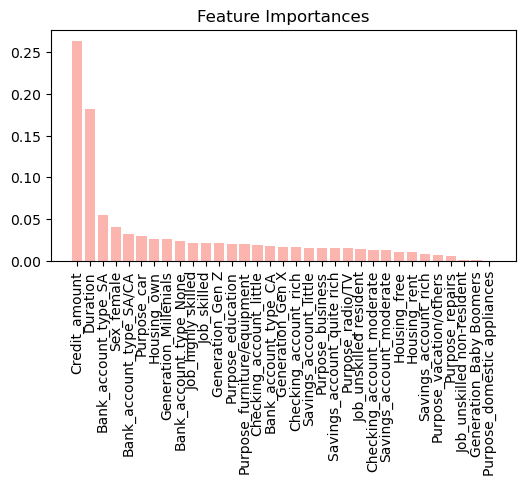

In [106]:
# extract feature importance scores from the classifier
importances = rf.feature_importances_

# get the indices of the featuresa sorted by importance score
indices = np.argsort(importances)[::-1]

# plot the feature importances
plt.figure(figsize=(6, 3))
plt.title("Feature Importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices])
plt.xticks(range(X_train_scaled.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

### Logistic Regression

In [86]:
import statsmodels.formula.api as smf

In [87]:
logitfit = smf.logit(formula = 'Risk ~ Credit_amount + Duration + C(Sex,Treatment(reference=1))+ C(Job) + C(Housing) + C(Savings_account) + C(Checking_account) + C(Purpose)+ C(Bank_account_type) + C(Generation)' , data = df_credit).fit() #   

Optimization terminated successfully.
         Current function value: 0.503849
         Iterations 6


In [88]:
#When preprocessing was made to numerical columns
# Apply log transformation to 'Credit_amount' and 'Duration'
df_credit['Credit_amount'] = np.log(df_credit['Credit_amount'])
df_credit['Duration'] = np.log(df_credit['Duration'])

# Scale 'Credit_amount' and 'Duration' using StandardScaler
df_credit[['Credit_amount', 'Duration']] = scaler.fit_transform(df_credit[['Credit_amount', 'Duration']])

# Fit the logistic regression model
logitfit = smf.logit(formula='Risk ~ Credit_amount + Duration + C(Sex, Treatment(reference=1)) + C(Job) + C(Housing) + C(Savings_account) + C(Checking_account) + C(Purpose) + C(Bank_account_type) + C(Generation)', data=df_credit).fit()

Optimization terminated successfully.
         Current function value: 0.501988
         Iterations 6


Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, making it difficult to determine the individual effect of each predictor on the target variable.
If credit amount and duration are known to be critical factors in assessing credit risk, it may be justifiable to retain them in the model despite multicollinearity. In such cases, it's essential to communicate the trade-offs to stakeholders and interpret the model results cautiously.
Some advanced modeling techniques, such as tree-based models (e.g., Random Forests, Gradient Boosting Machines), are less sensitive to multicollinearity compared to linear models like logistic regression. 

In [89]:
print(logitfit.summary())

                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      973
Method:                           MLE   Df Model:                           26
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.1782
Time:                        19:36:34   Log-Likelihood:                -501.99
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 3.378e-32
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.2620      0.534     -0.491      0.624      -1.308       0.784
C(Sex, Treatment(reference=1))[T.female] 

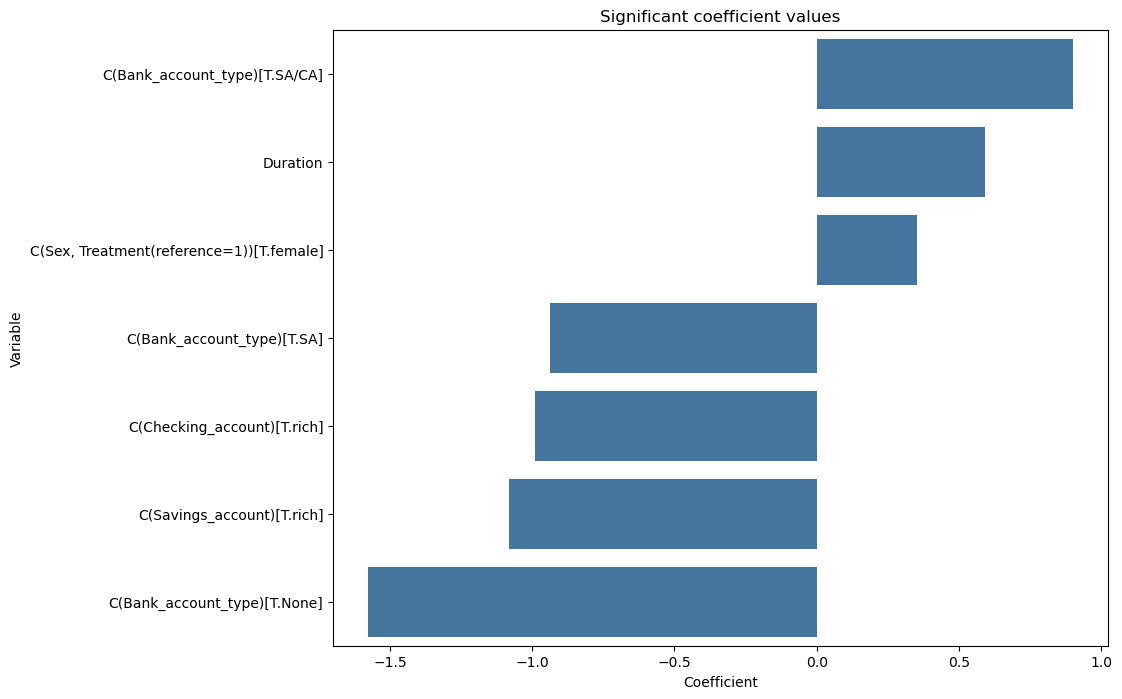

In [90]:
# Get coefficients with p-values less than 0.05
significant_coef = logitfit.params[logitfit.pvalues < 0.05].sort_values(ascending=False)

# Create horizontal bar plot of significant coefficients using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=significant_coef.values, y=significant_coef.index, color='#3776ab')

# Customize plot
plt.title('Significant coefficient values')
plt.xlabel('Coefficient')
plt.ylabel('Variable')

plt.show()

#### RFECV

In [112]:
# Initially encountered this increase the number of iterations (max_iter) or scale the data so I scaled then the data
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(5)

rfecv = RFECV(estimator=clf,step=1,cv=cv)
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 23


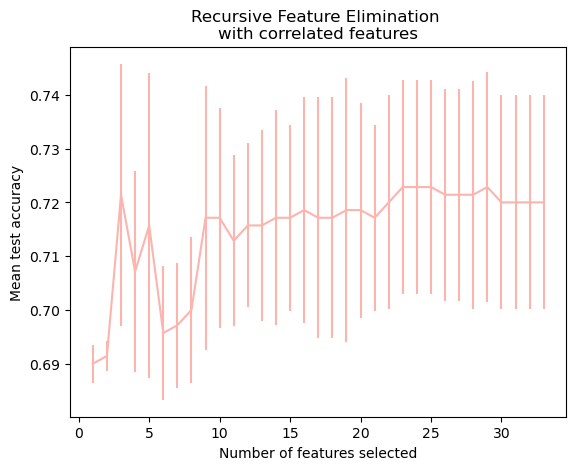

In [113]:
#Check the mean test accuracy of the RFECV as a function of the number of selected features.
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [115]:
# Get the mask of selected features
selected_features = rfecv.get_support()

# Get the names and rankings of selected features
feature_names = X_train.columns[selected_features]
feature_rankings = rfecv.ranking_[selected_features]

print("Selected features:")
for name, ranking in zip(feature_names, feature_rankings):
    print(f"{name} (Rank: {ranking})")

Selected features:
Credit_amount (Rank: 1)
Duration (Rank: 1)
Sex_female (Rank: 1)
Housing_free (Rank: 1)
Housing_own (Rank: 1)
Housing_rent (Rank: 1)
Savings_account_little (Rank: 1)
Savings_account_rich (Rank: 1)
Checking_account_little (Rank: 1)
Checking_account_moderate (Rank: 1)
Checking_account_rich (Rank: 1)
Purpose_car (Rank: 1)
Purpose_domestic appliances (Rank: 1)
Purpose_education (Rank: 1)
Purpose_radio/TV (Rank: 1)
Purpose_vacation/others (Rank: 1)
Generation_Gen Z (Rank: 1)
Generation_Gen X (Rank: 1)
Generation_Baby Boomers (Rank: 1)
Bank_account_type_CA (Rank: 1)
Bank_account_type_None (Rank: 1)
Bank_account_type_SA (Rank: 1)
Bank_account_type_SA/CA (Rank: 1)


#### LR Pipeline SelectKBest and PCA

In [118]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [119]:
features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('Select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('Feature_union', feature_union))
estimators.append(('Logistic_regression', LogisticRegression()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train_scaled, y_train, cv=kfold)
print(results.mean())

0.7271428571428571


In [120]:
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

0.7566666666666667


[[191  26]
 [ 47  36]]


In [110]:
# Access the selected features
selected_features_mask = model.named_steps['Feature_union'].transformer_list[1][1].get_support()

# Get the indices of selected features
selected_feature_indices = [i for i, selected in enumerate(selected_features_mask) if selected]

# Get the names of selected features
selected_feature_names = [X_train.columns[i] for i in selected_feature_indices]

print("Selected features:")
print(selected_feature_names)

Selected features:
['Credit_amount', 'Duration', 'Housing_own', 'Bank_account_type_None', 'Bank_account_type_SA', 'Bank_account_type_SA/CA']


Random forest with GridSearchCV and Logistic Regression with SelectKBest and Principal Component Analysis (PCA) somehow provides almost the same model accuracy and features selected. This proejcts provides insights what are the factors that could help when determining credit risks with bank debtors.